## Modeling
FNID: Fake News Inference Dataset - Predict Real/Fake News (Binary Classification)

In [1]:
# general packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import re
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.stats import zscore
sns.set()

### Load Data

In [2]:
# load fnid dataset
fnid = pd.read_csv('fakenn.csv')

print(fnid.shape)
fnid.head()

(17326, 8)


,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake


In [5]:
# check null data
fnid.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

In [11]:
# check values 
fnid['label_fnn'].value_counts()

real         8767
fake         8557
label_fnn       2
Name: label_fnn, dtype: int64

In [3]:
# drop data with no year information
fnid.drop(fnid[fnid['label_fnn'] == 'label_fnn'].index, inplace = True)

<IPython.core.display.Javascript object>


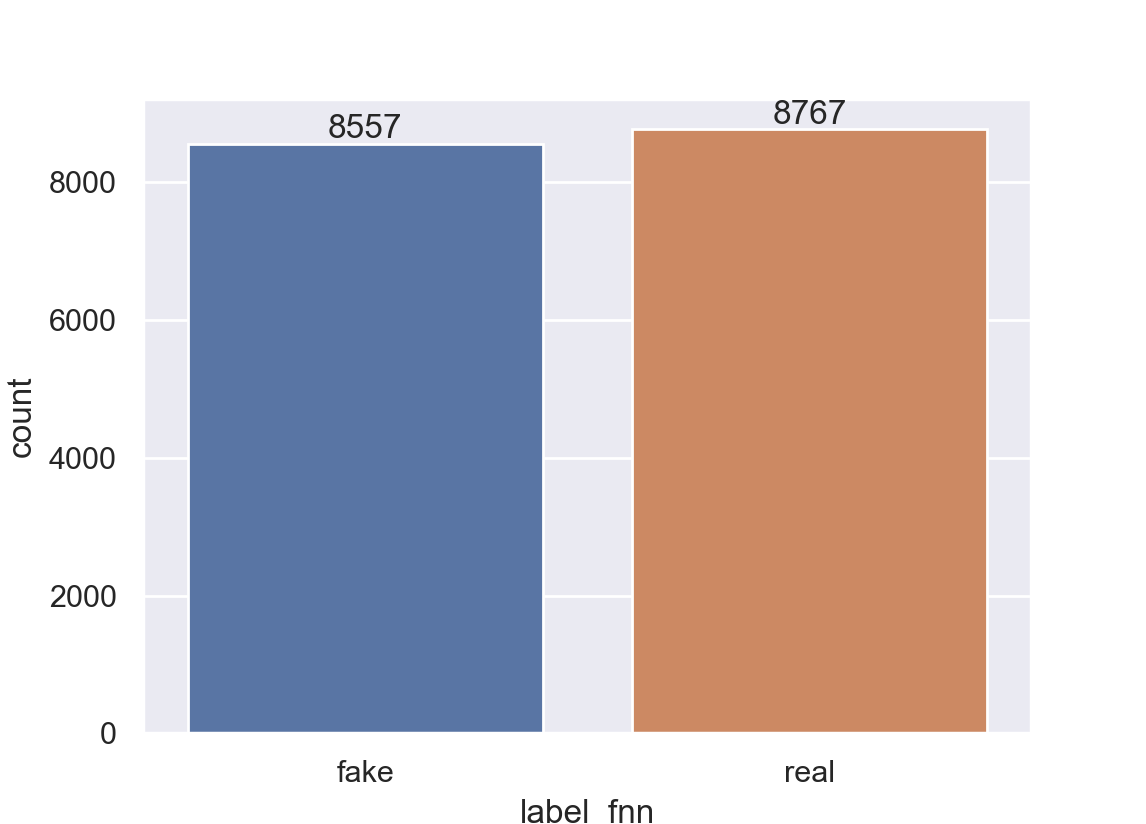

In [13]:
# balanced data
ax=sns.countplot(x="label_fnn", data=fnid)
for p in ax.patches:
    ax.annotate("%.f" % p.get_height(), xy=(p.get_x()+p.get_width()/2, p.get_height()),
            xytext=(0, 5), textcoords='offset points', ha="center", va="center");

### Preprocessing

In [4]:
# import nlp packages
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# possible stop words
nltk_stop = set(stopwords.words('english'))
gensim_stop = set(STOPWORDS)

In [25]:
# clean up text functions
def process_text(df):
    # take trailing/leading spaces
    df["clean_text"] = df["fullText_based_content"].str.strip()
    # remove punctuation
    df["clean_text"] = df["clean_text"].str.replace('[^\w\s]','')
    # lower case
    df["clean_text"] = df["clean_text"].str.lower()
    # remove stop words
    df["clean_text"] = df["clean_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (gensim_stop)]))
    # lemmatize and tokenize
    df["clean_text"] = df["clean_text"].apply(lambda x: token_text(x))
    return df

def process_text2(df):
    # take trailing/leading spaces
    df["clean_text"] = df["fullText_based_content"].str.strip()
    # remove punctuation
    df["clean_text"] = df["clean_text"].str.replace('[^\w\s]','')
    # lower case
    df["clean_text"] = df["clean_text"].str.lower()
    # remove stop words
    df["clean_text"] = df["clean_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (gensim_stop)]))
    # lemmatize and tokenize
    #df["clean_text"] = df["clean_text"].apply(lambda x: token_text(x))
    return df

def token_text(article):
    lemmatizer = WordNetLemmatizer() 
    # tokenize
    words = word_tokenize(article)
    # lemmatize
    words = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return words    

In [7]:
# clean up dataframe
fnid_copy = fnid.copy()
fnid_copy.head()
fnid_copy = process_text(fnid_copy)
fnid_copy.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn,clean_text
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake,gov charlie crist launched amount nuclear atta...
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,rep bobby scott d3rd pleased debt limit deal l...
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake,amid report questioning foxconn technology gro...
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real,state sen dave aronberg democratic candidate a...
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake,citrus rio grande valley peach texas hill coun...


In [8]:
# encode 
labels=['fake','real']
fnid_copy['news_class'] = np.where(fnid_copy['label_fnn']=='fake', 0, 1)
fnid_copy.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn,clean_text,news_class
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake,gov charlie crist launched amount nuclear atta...,0
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real,rep bobby scott d3rd pleased debt limit deal l...,1
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake,amid report questioning foxconn technology gro...,0
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real,state sen dave aronberg democratic candidate a...,1
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake,citrus rio grande valley peach texas hill coun...,0


In [31]:
# save data for modeling
fnid_copy.to_csv('fnid_modeling.csv') 

# fnid_copy = pd.read_csv('fnid_modeling.csv')

In [9]:
# X and y - text and class
X = fnid_copy['clean_text'].values.astype('str')
y = fnid_copy['news_class']

X[:2]

array(['gov charlie crist launched amount nuclear attack republican politics fox news sunday showdown marco rubio crist labeled rubio house speaker tax raiser forth record tax issue crist singled rubios failed 2007 plan eliminated property tax floridian exchange increase state sale tax tax swap massive tax increase crist said march 28 2010 senate debate respect speaker youve got tell truth people thats rubio contends tax swap huge net tax cut plan supported gov jeb bush tax cut tax hike let look month speaker early 2007 rubio proposed fundamental change florida tax structure proposal scratch property tax primary residence place state sale tax increased 25 cent dollar subject voter approval house analysis originally said swap save taxpayer total 58 billion year certainly contrary crists claim saved money spent money end year likely depended individual circumstance 2007 st petersburg time ran calculation rubios proposal homeowner renter homeowner family annual income 64280 home value 241

In [11]:
# train test split
from sklearn.model_selection import train_test_split

In [12]:
# train/test split
trainX, testX, trainY, testY = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

### Modeling

In [13]:
# load model preprocessing 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [14]:
# load models
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [15]:
# create function to train and report metrics
def fit_model(model, X, y, scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']):
    model.fit(X, y)
    preds = model.predict(X)
    print('Training Metrics: ')
    print(metrics.classification_report(y, preds))
    # cross validation
    cv_scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    print('Cross Validation (CV) Metrics:')
    print('Average CV Accuracy: ', cv_scores['test_accuracy'].mean())
    print('Average CV Precision: ', cv_scores['test_precision_macro'].mean())
    print('Average CV Recall: ', cv_scores['test_recall_macro'].mean())
    print('Average CV F1 Score: ', cv_scores['test_f1_macro'].mean())


def test_metrics(model, X, y, labels):
    preds = model.predict(X)
    print('Testing Metrics: ')
    print(metrics.classification_report(y, preds))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # plot confusion matrix (normalized and roc curve)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.heatmap(cm_norm, annot=True, cmap="Blues", annot_kws={"fontsize":10}, ax=ax[0])
    ax[0].set_xlabel('Predicted', fontsize=8)
    ax[0].set_ylabel('Actual', fontsize=8)
    ax[0].set_title('Normalized Confusion Matrix', fontsize=12, pad=12)
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)

    fpr, tpr, _ = metrics.roc_curve(y, preds)
    ax[1].plot(fpr, tpr)
    ax[1].plot([0,1], [0,1], linestyle='--')
    ax[1].set_xlabel('False Positive Rate', fontsize=8)
    ax[1].set_ylabel('True Positive Rate', fontsize=8)
    ax[1].set_title('ROC Curve', fontsize=12, pad=12)
    fig.tight_layout()

#### Logistic Regression

In [37]:
# fit general logistic model
pipe_lr = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression( random_state=42))])
fit_model(pipe_lr, trainX, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      6865
           1       0.80      0.87      0.83      6994

    accuracy                           0.82     13859
   macro avg       0.83      0.82      0.82     13859
weighted avg       0.83      0.82      0.82     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.6850412607073171
Average CV Precision:  0.6870020703237069
Average CV Recall:  0.684521634906783
Average CV F1 Score:  0.6838147431776028


In [40]:
# logistic regression - tune
lr_params = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95),
             'lr__penalty': ('l1','l2'),
             'lr__C': (0.01, 0.1, 1)}

lr_search = RandomizedSearchCV(pipe_lr, param_distributions=lr_params,
                                   cv=5, random_state=42, return_train_score=True)
lr_search.fit(trainX, trainY)

print("Best Hyperparameters:",lr_search.best_params_)
print("Best CV score is {}".format(lr_search.best_score_))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Hyperparameters: {'tfidf__max_df': 0.9, 'lr__penalty': 'l1', 'lr__C': 1}
Best CV score is 0.7107294898621834


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1692
           1       0.70      0.79      0.74      1773

    accuracy                           0.72      3465
   macro avg       0.72      0.72      0.71      3465
weighted avg       0.72      0.72      0.72      3465



<IPython.core.display.Javascript object>


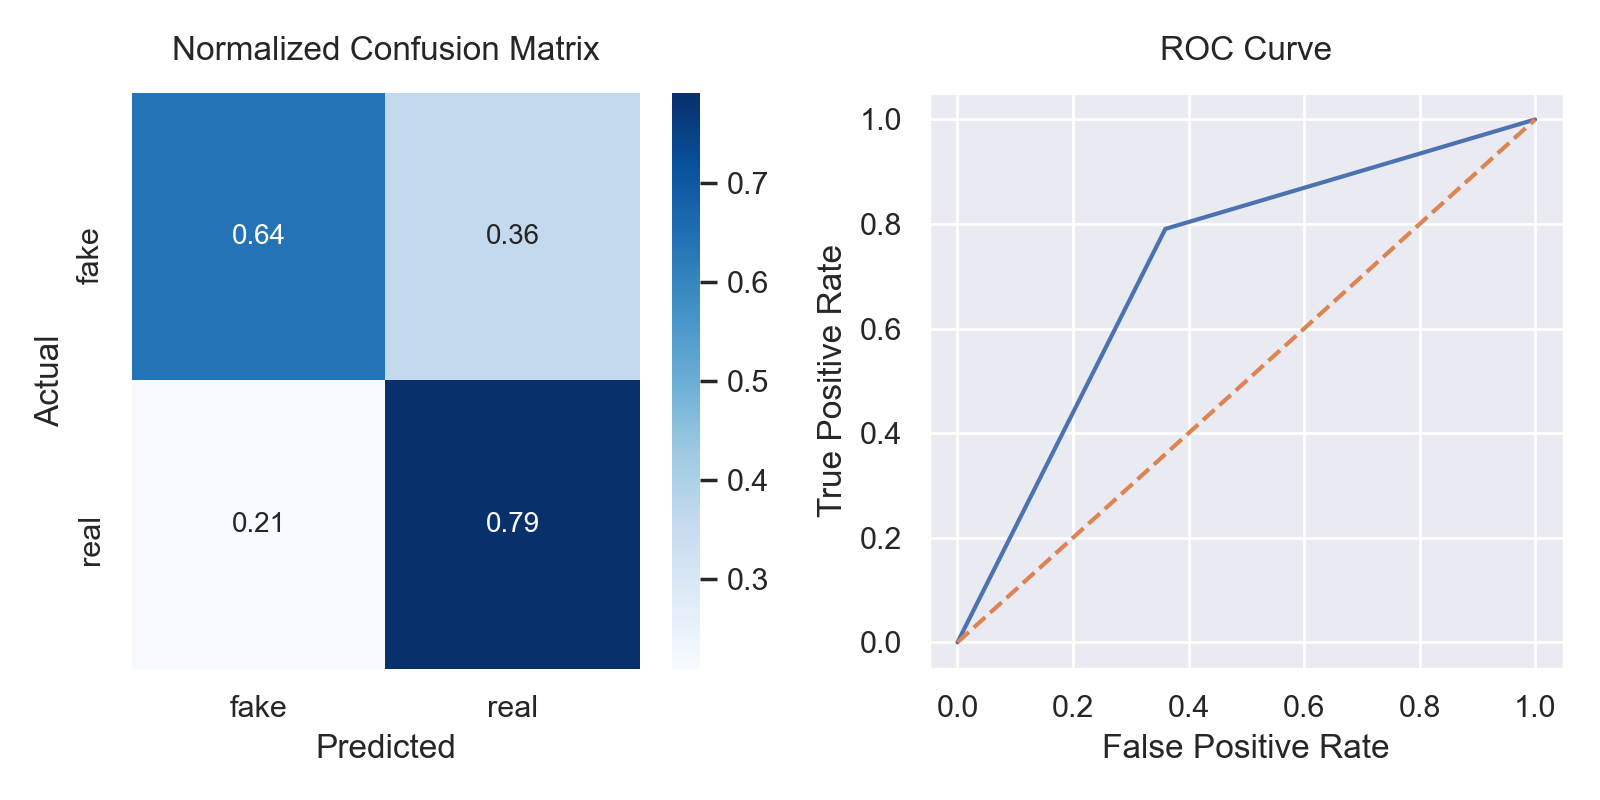

In [54]:
# test logistic
test_metrics(lr_search.best_estimator_, testX, testY, labels)

In [16]:
# vectorize on one percentage for rest of modeling
tfidf_vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(trainX) 
tfidf_test = tfidf_vectorizer.transform(testX)

In [17]:
# logistic regression 0.7 vocab
fit_model(LogisticRegression(random_state=42), tfidf_train, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      6865
           1       0.80      0.87      0.83      6994

    accuracy                           0.82     13859
   macro avg       0.83      0.82      0.82     13859
weighted avg       0.83      0.82      0.82     13859



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation (CV) Metrics:
Average CV Accuracy:  0.688288671110757
Average CV Precision:  0.6904448472238843
Average CV Recall:  0.6877581110332326
Average CV F1 Score:  0.6869960293148993


In [26]:
# try on bag of word (Count Vectorizer)
pipe_lr_bow = Pipeline([('vec', CountVectorizer()), ('lr', LogisticRegression(random_state=42))])
fit_model(pipe_lr_bow, trainX, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6865
           1       1.00      1.00      1.00      6994

    accuracy                           1.00     13859
   macro avg       1.00      1.00      1.00     13859
weighted avg       1.00      1.00      1.00     13859



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation (CV) Metrics:
Average CV Accuracy:  0.6890105363580643
Average CV Precision:  0.6891539442404626
Average CV Recall:  0.68886503481367
Average CV F1 Score:  0.6888265153767368


#### Naive Bayes

In [18]:
# naive bayes classifier (multinomial)
nb = MultinomialNB()
fit_model(nb, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.83      0.61      0.70      6865
           1       0.70      0.87      0.77      6994

    accuracy                           0.74     13859
   macro avg       0.76      0.74      0.74     13859
weighted avg       0.76      0.74      0.74     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.6543041644990399
Average CV Precision:  0.6680714727314113
Average CV Recall:  0.6529223530390228
Average CV F1 Score:  0.6458357691976909


#### Passive Agressive Classifier

In [19]:
# passive aggressive classifier
pa = PassiveAggressiveClassifier(max_iter=50)
fit_model(pa, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6865
           1       1.00      1.00      1.00      6994

    accuracy                           1.00     13859
   macro avg       1.00      1.00      1.00     13859
weighted avg       1.00      1.00      1.00     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.6762388539725241
Average CV Precision:  0.6762692780156871
Average CV Recall:  0.6761435696145404
Average CV F1 Score:  0.6761297628937244


#### Support Vector Machine (SVM)

In [20]:
# svm classifier - did not really work and took a very long time
svc = svm.SVC(random_state=42)
fit_model(svc, tfidf_train, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6865
           1       0.50      1.00      0.67      6994

    accuracy                           0.50     13859
   macro avg       0.25      0.50      0.34     13859
weighted avg       0.25      0.50      0.34     13859



/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled fe

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.50465400512315
Average CV Precision:  0.252327002561575
Average CV Recall:  0.5
Average CV F1 Score:  0.3353953806966158


/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Random Forest

In [21]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)
fit_model(rf, tfidf_train, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6865
           1       0.99      0.98      0.99      6994

    accuracy                           0.99     13859
   macro avg       0.99      0.99      0.99     13859
weighted avg       0.99      0.99      0.99     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.62096817533483
Average CV Precision:  0.6230789570316798
Average CV Recall:  0.6214928609377974
Average CV F1 Score:  0.6198980878056365


In [22]:
# RF tune
rf_params = {'n_estimators': [50, 75, 100, 200], 
                  'max_features': ['auto', 'sqrt', 'log2', None], 
                  'max_depth': [5,6,8,10, None]}


rf_search = RandomizedSearchCV(rf, param_distributions=rf_params,
                                   cv=5, random_state=42, return_train_score=True)
rf_search.fit(tfidf_train, trainY)

print("Best Hyperparameters:",rf_search.best_params_)
print("Best CV score is {}".format(rf_search.best_score_))

Best Hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None}
Best CV score is 0.6832383288837578


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1692
           1       0.68      0.78      0.73      1773

    accuracy                           0.70      3465
   macro avg       0.70      0.70      0.69      3465
weighted avg       0.70      0.70      0.69      3465



<IPython.core.display.Javascript object>


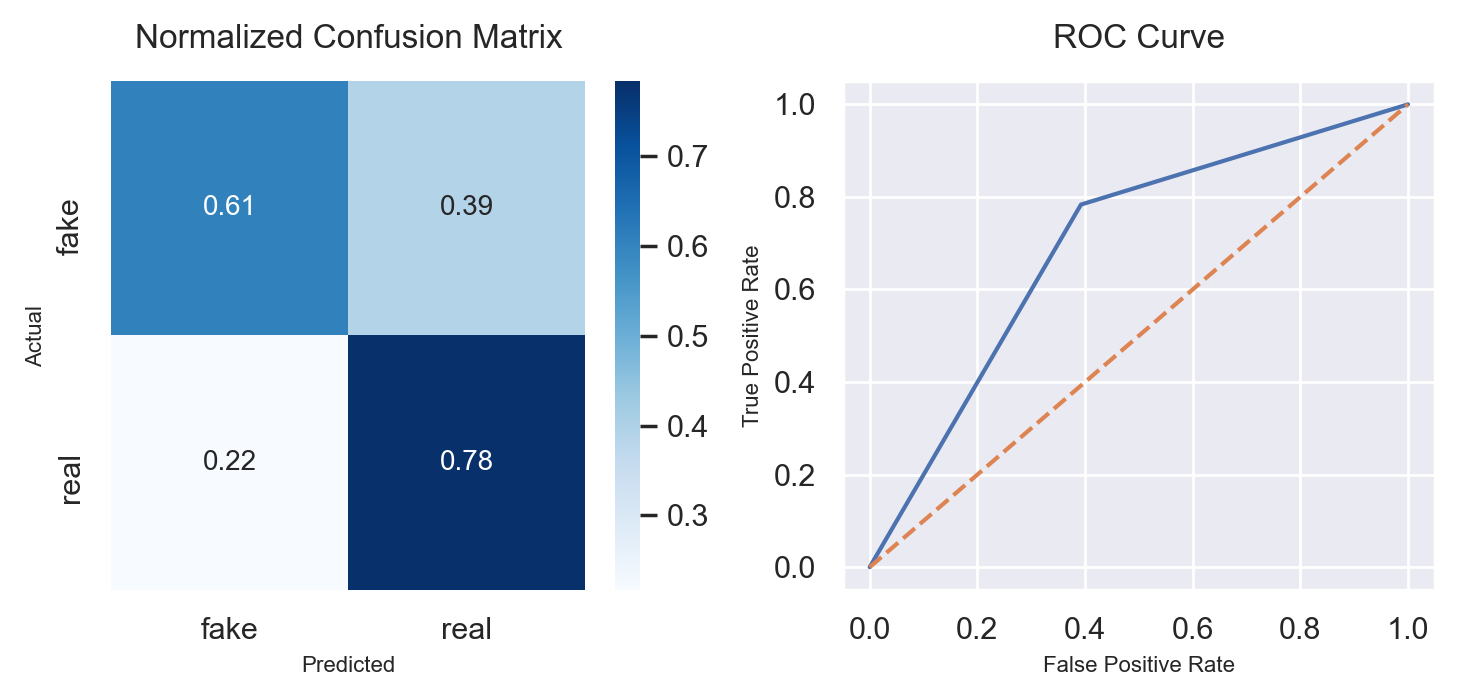

In [28]:
# test rf
test_metrics(rf_search.best_estimator_, tfidf_test, testY, labels)

#### Boosting
Gradient Boosting and XGBoost

In [23]:
# gradient boosting classifier - tried tuning but timed out
gb = GradientBoostingClassifier(random_state=42)
fit_model(gb, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      6865
           1       0.72      0.84      0.78      6994

    accuracy                           0.76     13859
   macro avg       0.77      0.76      0.76     13859
weighted avg       0.76      0.76      0.76     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7102967604591567
Average CV Precision:  0.7167014616139958
Average CV Recall:  0.7094750449543531
Average CV F1 Score:  0.7075920266350264


In [24]:
# xgb classifier - tried tuning but timed out
xgb = xgb.XGBClassifier(random_state=42)
fit_model(xgb, tfidf_train, trainY)

Training Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      6865
           1       0.95      0.98      0.97      6994

    accuracy                           0.96     13859
   macro avg       0.96      0.96      0.96     13859
weighted avg       0.96      0.96      0.96     13859

Cross Validation (CV) Metrics:
Average CV Accuracy:  0.7071213240827098
Average CV Precision:  0.7080696427351465
Average CV Recall:  0.7067881898848867
Average CV F1 Score:  0.7065333016195358


Testing Metrics: 
              precision    recall  f1-score   support

           0       0.73      0.66      0.70      1692
           1       0.71      0.77      0.73      1773

    accuracy                           0.72      3465
   macro avg       0.72      0.72      0.72      3465
weighted avg       0.72      0.72      0.72      3465



<IPython.core.display.Javascript object>


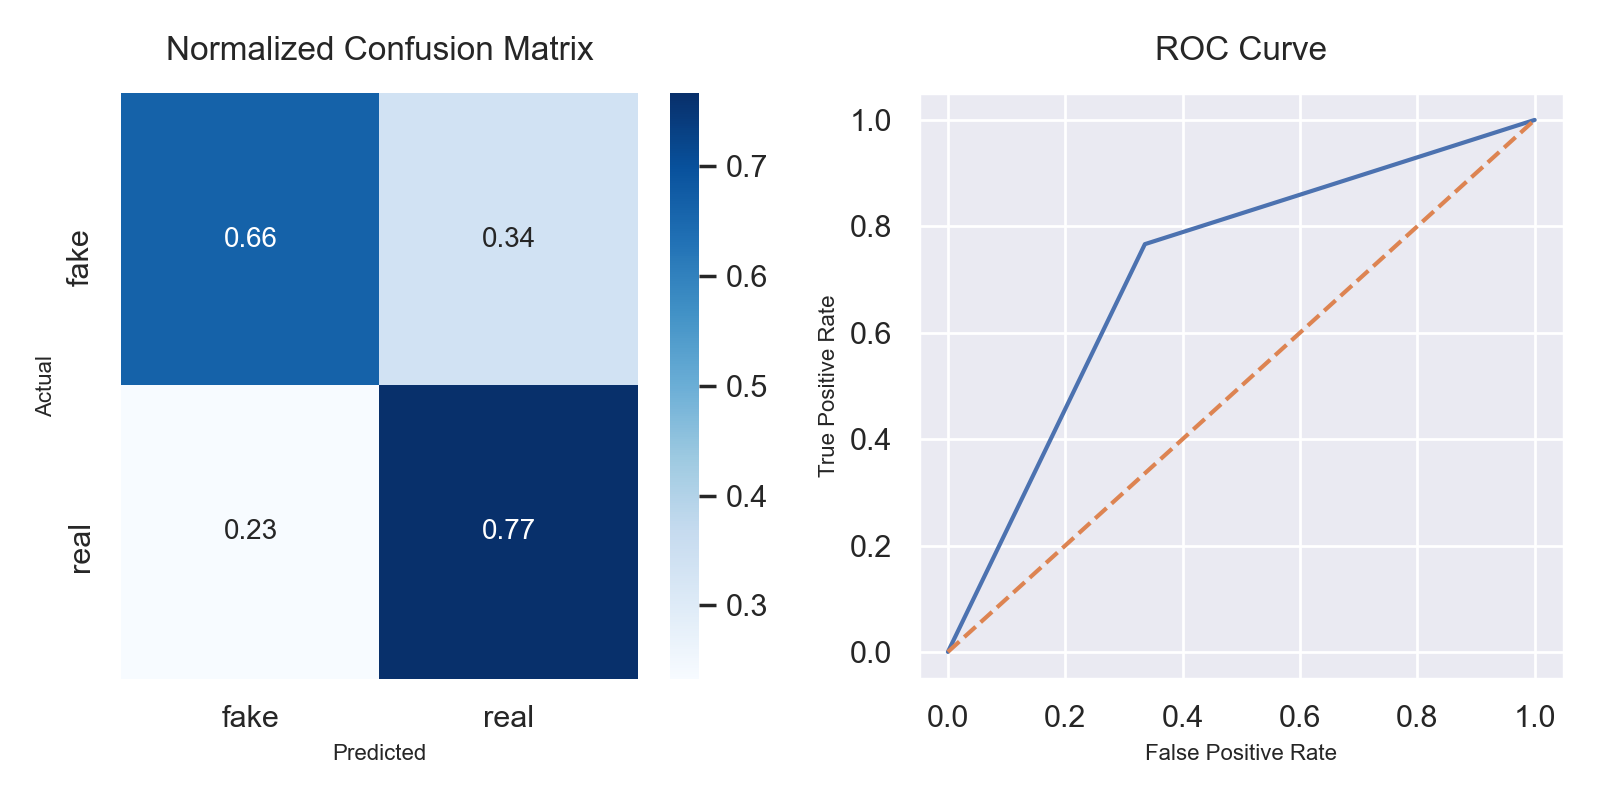

In [29]:
# test xgb
test_metrics(xgb, tfidf_test, testY, labels)

In [31]:
xgb_preds_test = xgb.predict(tfidf_test)
metrics.roc_auc_score(xgb_preds_test, testY)

0.7180302767529793